# Spatial Calibration by Automatic Differentiation

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.polynomials import noll_to_nm, sum_of_2d_modes
from prysm.polynomials import zernike_nm_seq as zernike_nm_sequence
from prysm.geometry import circle

from katsu.mueller import (
    linear_diattenuator,
    linear_retarder,
    linear_polarizer
)

from katsu.katsu_math import np, set_backend_to_jax, broadcast_kron
import numpy as tnp

# Plotting stuff

plt.style.use('bmh')
okabe_colorblind8 = [
'#E69F00',
'#56B4E9',
'#009E73',
'#F0E442',
'#0072B2',
'#D55E00',
'#CC79A7',
'#000000',
]
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe_colorblind8)


def plot_square(x,n=4,vmin=None,vmax=None, common_cbar=True):
    """A simple plotting macro for viewing intermediate results
    """
    k = 1
    plt.figure(figsize=[10,10])
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            im = plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            if not common_cbar:
                plt.colorbar()
            k += 1

    if common_cbar:
        ax = plt.gca()
        cbar = plt.colorbar(im, ax=ax)
    
    plt.show()


def jax_sum_of_2d_modes(modes, weights):
    """a clone of prysm.polynomials sum_of_2d_modes that works when using katsu's Jax backend

    Parameters
    ----------
    modes : list of ndarrays
        list of polynomials constituting the desired basis
    weights : list of floats
        coefficients that describe the presence of each mode in the modes list

    Returns
    -------
    ndarray
        2D ndarray containing the sum of weighted modes
    """
    modes = np.asarray(modes)
    weights = np.asarray(weights).astype(modes.dtype)

    # dot product of the 0th dim of modes and weights => weighted sum
    return np.tensordot(modes, weights, axes=(0, 0))

def sum_of_2d_modes_wrapper(modes, weights):
    """ Wrapper that lets us ignore which source module we want to use
    """
    if np._srcmodule == tnp:
        return sum_of_2d_modes(modes, weights)
    else:
        return jax_sum_of_2d_modes(modes, weights)

In [2]:
1/(5 * (np.pi/180) / (2 * np.pi))

72.0

We begin by initializing a polynomial basis using the `prysm` optical propagation tool, which contains highly efficient routines for generating various polynomials. In this study, we elect to use the Zernike polynomial basis due to their orthonormality enabling more efficient optimization, but this is simply an illustrative choice that is not grounded in the physics that give rise to nonuniformities in retarders. Any choice of basis is likely sufficient, and the user should use one that is appropriate for their use case.

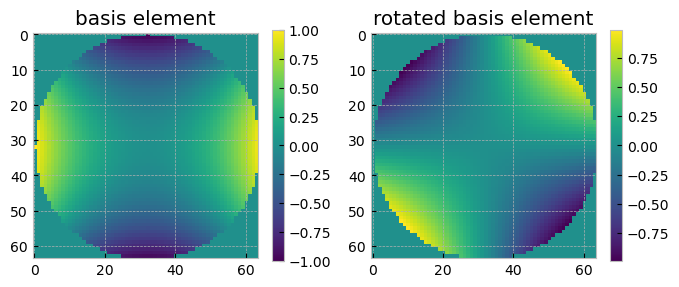

In [3]:
NPIX = 64
NMODES = 128
NMEAS = 24


x, y = make_xy_grid(NPIX, diameter=2)
r, t = cart_to_polar(x, y)

def construct_zern_basis(r, t):

    nms = [noll_to_nm(i) for i in range(1, NMODES)]

    # Norm = False is required to have unit peak-to-valley
    basis_full = list(zernike_nm_sequence(nms, r, t, norm=False))
    A = circle(1, r) # a circular mask to apply to the beam
    basis = [mode * A for mode in basis_full ]

    return basis

A = circle(1, r)
LS = circle(0.9, r)
basis = construct_zern_basis(r, t)
basis_rotated = construct_zern_basis(r, t + np.pi / 4)
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.title("basis element")
plt.imshow(basis[5])
plt.colorbar()
plt.subplot(122)
plt.title("rotated basis element")
plt.imshow(basis_rotated[5])
plt.colorbar()
plt.show()

We next define a forward model that generally supports spatially-varying retarders that can rotate.

In [10]:
def rotation_matrix(th):
    return np.array([[np.cos(th), -np.sin(th)],
                     [np.sin(th), np.cos(th)]])

def forward_simulate(x):

    ROTATION_RATIO = 2.5
    END_ANGLE_PSG = 180

    # unpack the parameters
    theta_pg = x[0] # Starting angle of the polarizer
    theta_pa = x[1] # Starting angle of the polarizer

    # get spatially varying coefficcients
    coeffs_spatial_ret_psg = x[2 : 2 + 1*len(basis)]
    coeffs_spatial_ang_psg = x[2 + 1*len(basis):(2 + 2*len(basis))]
    coeffs_spatial_ret_psa = x[2 + 2*len(basis):(2 + 3*len(basis))]
    coeffs_spatial_ang_psa = x[2 + 3*len(basis):(2 + 4*len(basis))]

    # set up the basis with rotation
    x, y = make_xy_grid(NPIX, diameter=2)
    r, t = cart_to_polar(x, y)

    # the nominal rotations performed
    rotations_psg = np.linspace(0, np.radians(END_ANGLE_PSG), NMEAS)
    rotations_psa = rotations_psg * ROTATION_RATIO

    psg_retardances, psa_retardances = [], []
    psg_fast_axes, psa_fast_axes = [], []

    for rot_psg, rot_psa in zip(rotations_psg, rotations_psa):

        # Get the rotated spatial basis
        basis_psg = np.asarray(construct_zern_basis(r, t + rot_psg))
        basis_psa = np.asarray(construct_zern_basis(r, t + rot_psa))

        # compute retardances
        psg_retardance = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ret_psg)
        psa_retardance = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ret_psa)

        # compute fast axes
        psg_fast_axis = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ang_psg)
        psa_fast_axis = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ang_psa)

        # store arrays in list
        psg_retardances.append(psg_retardance)
        psa_retardances.append(psa_retardance)
        psg_fast_axes.append(psg_fast_axis)
        psa_fast_axes.append(psa_fast_axis)

    # get lists as arrays
    psg_retardances = np.asarray(psg_retardances)
    psa_retardances = np.asarray(psa_retardances)
    psg_fast_axes = np.asarray(psg_fast_axes) + rotations_psg[..., None, None]
    psa_fast_axes = np.asarray(psa_fast_axes) + rotations_psa[..., None, None]

    # swap axes around
    psg_retardances = np.moveaxis(psg_retardances, 0, -1)
    psa_retardances = np.moveaxis(psa_retardances, 0, -1)
    psg_fast_axes = np.moveaxis(psg_fast_axes, 0, -1)
    psa_fast_axes = np.moveaxis(psa_fast_axes, 0, -1)

    # set up the drrp
    psg_pol = linear_polarizer(theta_pg, shape=[NMEAS])
    psg_wvp = linear_retarder(psg_fast_axes, psg_retardances, shape=[NPIX, NPIX, NMEAS])

    psa_wvp = linear_retarder(psa_fast_axes, psa_retardances, shape=[NPIX, NPIX, NMEAS])
    psa_pol = linear_polarizer(theta_pa, shape=[NMEAS])

    # Create power measurements
    power_measured = (psa_pol @ psa_wvp @ psg_wvp @ psg_pol)[..., 0, 0]

    return power_measured

The next step is to define our ground truth parameters.

In [11]:
# ground truth
SCALE = 100
theta_pg = np.radians(0)
theta_pa = np.radians(0)

# Init retardance, PSG
tnp.random.seed(24601)
coeffs_spatial_ret_psg = tnp.random.random(len(basis)) / SCALE
coeffs_spatial_ret_psg[0] = np.pi / 2

# Init angle, PSG
tnp.random.seed(8675309)
coeffs_spatial_ang_psg = tnp.random.random(len(basis)) / (SCALE * 4)
coeffs_spatial_ang_psg[0] = theta_pg #tnp.random.random()

# Init retardance, PSA
tnp.random.seed(24603)
coeffs_spatial_ret_psa = tnp.random.random(len(basis)) / SCALE
coeffs_spatial_ret_psa[0] = np.pi / 2

# Init angle, PSA
tnp.random.seed(24604)
coeffs_spatial_ang_psa = tnp.random.random(len(basis)) / (SCALE * 4)
coeffs_spatial_ang_psa[0] = theta_pa # tnp.random.random()

x0_truth = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])
power_experiment = forward_simulate(x0_truth)

/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/2440848462.py:12: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.degrees(retardance_psg) / A, cmap="PuOr_r", vmin=90 - vlim_ret, vmax=90 + vlim_ret)
/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/2440848462.py:19: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.degrees(retardance_psa) / A, cmap="PuOr_r", vmin=90 - vlim_ret, vmax=90 + vlim_ret)
/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/2440848462.py:24: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.degrees(angle_psg) / A, cmap="PiYG_r", vmin=np.mean(np.degrees(angle_psg[A==1])) - vlim_ang,
/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/2440848462.py:31: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.degrees(angle_psa) / A, cmap="PiYG_r", vmin=np.mean(np.degrees(angle_psa[A==1])) - vlim_ang,


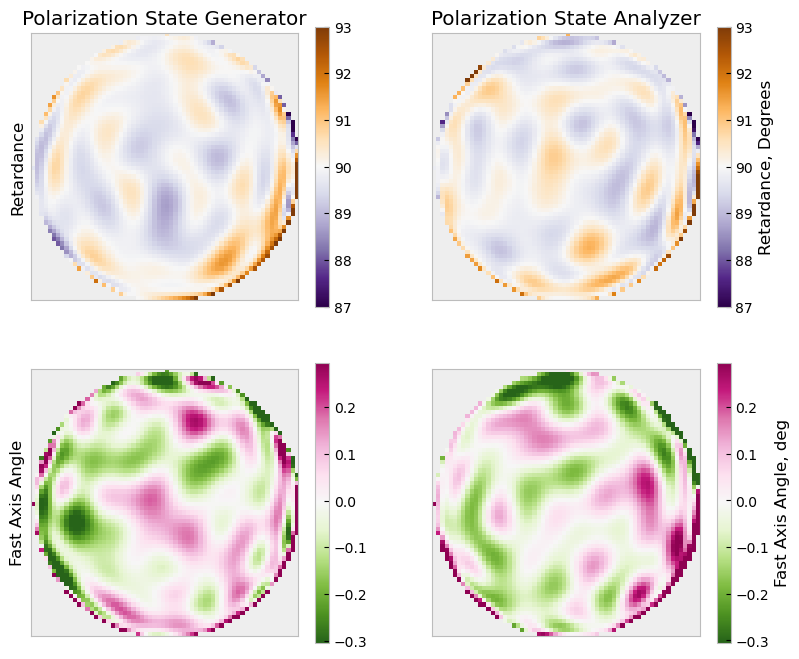

In [12]:
# plot the ground truth retardance and angles
retardance_psg = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ret_psg)
retardance_psa = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ret_psa)
angle_psg = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ang_psg)
angle_psa = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ang_psa)

plt.figure(figsize=[9.5,8])
plt.subplot(221)
vlim_ret = 3
vlim_ang = .3
plt.title("Polarization State Generator")
plt.imshow(np.degrees(retardance_psg) / A, cmap="PuOr_r", vmin=90 - vlim_ret, vmax=90 + vlim_ret)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.ylabel("Retardance")
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow(np.degrees(retardance_psa) / A, cmap="PuOr_r", vmin=90 - vlim_ret, vmax=90 + vlim_ret)
plt.colorbar(label="Retardance, Degrees")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg) / A, cmap="PiYG_r", vmin=np.mean(np.degrees(angle_psg[A==1])) - vlim_ang,
                                                     vmax=np.mean(np.degrees(angle_psg[A==1])) + vlim_ang)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.ylabel("Fast Axis Angle")
plt.subplot(224)
plt.imshow(np.degrees(angle_psa) / A, cmap="PiYG_r", vmin=np.mean(np.degrees(angle_psa[A==1])) - vlim_ang,
                                                     vmax=np.mean(np.degrees(angle_psa[A==1])) + vlim_ang)
plt.colorbar(label="Fast Axis Angle, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

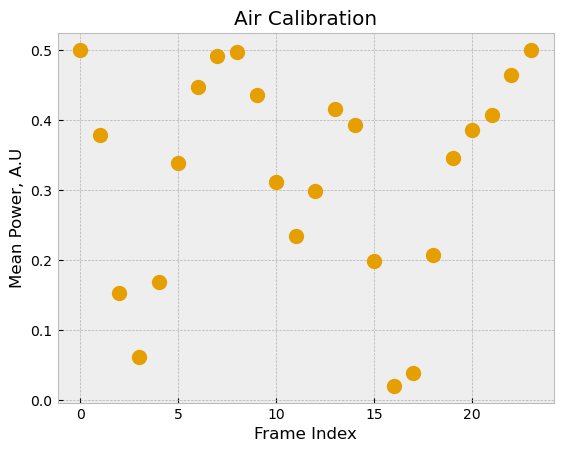

In [13]:
mean_power = []
N_PHOTONS = 1
for i in range(NMEAS):
    frame = power_experiment[..., i]
    mean_power.append(np.mean(((N_PHOTONS * frame[LS==1]))))
    
plt.figure()
plt.plot(mean_power, marker="o", linestyle="None", markersize=10)
plt.ylabel("Mean Power, A.U")
plt.xlabel("Frame Index")
plt.title("Air Calibration")
plt.show()

Now we would originally fit to the angles that best represent these data points using the pupil-averaged data like we would for a normal calibration.

In [14]:
from scipy.optimize import minimize
from tqdm import tqdm

MAX_ITERS = 100

# Init some guess parameters
tnp.random.seed(123)
theta_pg = 0 # tnp.random.random()
theta_pa = 0 # tnp.random.random()

ret_pg = np.pi / 2 #+ tnp.random.random()
ret_pa = np.pi / 2 #+ tnp.random.random()

fast_pg = 0 #tnp.random.random()
fast_pa = 0 #tnp.random.random()

x0 = np.array([theta_pa, theta_pg, ret_pg, fast_pg, ret_pa, fast_pa])


# simple MSE loss function
def forward_simulate_pupil_avg(x, NPTS=NMEAS):

    ROTATION_RATIO = 2.5
    END_ANGLE_PSG = 180

    # unpack the parameters
    theta_pg = x[0] # Starting angle of the polarizer
    theta_pa = x[1] # Starting angle of the polarizer

    # get spatially varying coefficcients
    ret_psg = x[2]
    ang_psg = x[3]
    ret_psa = x[4]
    ang_psa = x[5]

    # the nominal rotations performed
    rotations_psg = np.linspace(0, np.radians(END_ANGLE_PSG), NPTS)
    rotations_psa = rotations_psg * ROTATION_RATIO

    # construct the data reduction matrices
    psg_pol = linear_polarizer(theta_pg)
    psg_wvp = linear_retarder(ang_psg + rotations_psg, ret_psg, shape=[*rotations_psg.shape])
    psa_wvp = linear_retarder(ang_psa + rotations_psa, ret_psa, shape=[*rotations_psg.shape])
    psa_pol = linear_polarizer(theta_pa)

    power = (psa_pol @ psa_wvp @ psg_wvp @ psg_pol)[..., 0, 0] * N_PHOTONS

    return power


def loss(x):
    diff = forward_simulate_pupil_avg(x) - mean_power
    diffsq = diff**2
    return np.sum(diffsq)

def callback(xk):
    pbar.update(1)

with tqdm(total=MAX_ITERS) as pbar:
    results = minimize(loss, x0=x0, callback=callback, method="L-BFGS-B", jac=False,
                       options={"maxiter": MAX_ITERS, "disp":False, "memory":10})

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/1914329892.py:60: OptimizeWarning: Unknown solver options: memory
  results = minimize(loss, x0=x0, callback=callback, method="L-BFGS-B", jac=False,
 10%|█         | 10/100 [00:00<00:00, 160.93it/s]


And now we let L-BFGS-B do it's thing, to get an understanding of how we did, let's superimpose the modeled power with the measured power

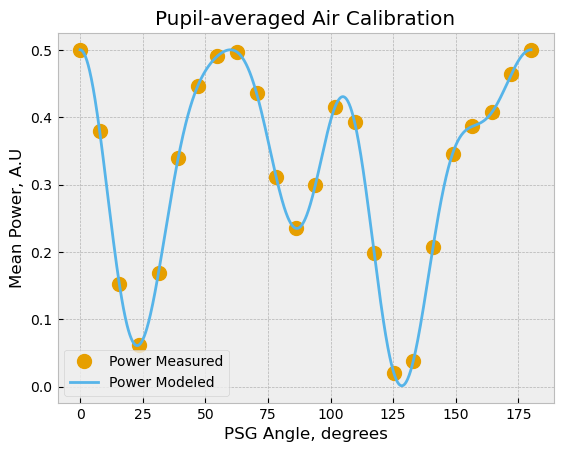

In [15]:
psg_angles_highsample = np.linspace(0, 180, 1000)
psg_angles = np.linspace(0, 180, NMEAS)
power_modeled = forward_simulate_pupil_avg(results.x, NPTS=1000)


plt.figure()
plt.plot(psg_angles, mean_power, marker="o", linestyle="None", markersize=10, label="Power Measured")
plt.plot(psg_angles_highsample, power_modeled, linestyle="solid", label="Power Modeled")
plt.ylabel("Mean Power, A.U")
plt.xlabel("PSG Angle, degrees")
plt.title("Pupil-averaged Air Calibration")
plt.legend()
plt.show()

Now do the data reduction assuming spatially-ignorant calibration

In [16]:
print(results)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.3036987211053016e-09
        x: [ 9.100e-05  1.281e-04  1.570e+00 -8.849e-05  1.570e+00
            -1.312e-04]
      nit: 10
      jac: [-4.639e-06  9.529e-06  1.921e-05 -1.262e-05 -2.144e-05
             7.830e-06]
     nfev: 91
     njev: 13
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [17]:
from katsu.polarimetry import drrp_data_reduction_matrix

psg_pol = linear_polarizer(results.x[0], shape=[NPIX, NPIX, NMEAS])
psa_pol = linear_polarizer(results.x[1], shape=[NPIX, NPIX, NMEAS])

psg_wvp = linear_retarder(results.x[3] + np.radians(psg_angles), results.x[2], shape=[NPIX, NPIX, NMEAS])
psa_wvp = linear_retarder(results.x[5] + (np.radians(psg_angles) * 2.5), results.x[4], shape=[NPIX, NPIX, NMEAS])

PSG = (psg_wvp @ psg_pol)
PSA = (psa_pol @ psa_wvp)
Winv = drrp_data_reduction_matrix(PSG, PSA, invert=True)

M_meas = Winv @ (N_PHOTONS * (power_experiment - 1e-7))[..., None]
M_meas = np.reshape(M_meas[..., 0], [NPIX, NPIX, 4, 4])

/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/2416946421.py:4: RuntimeWarning: divide by zero encountered in divide
  plot_square(M_meas / M_meas[..., 0, 0, None, None] / lyot_stop[...,None,None], vmin=-1.1, vmax=1.1)


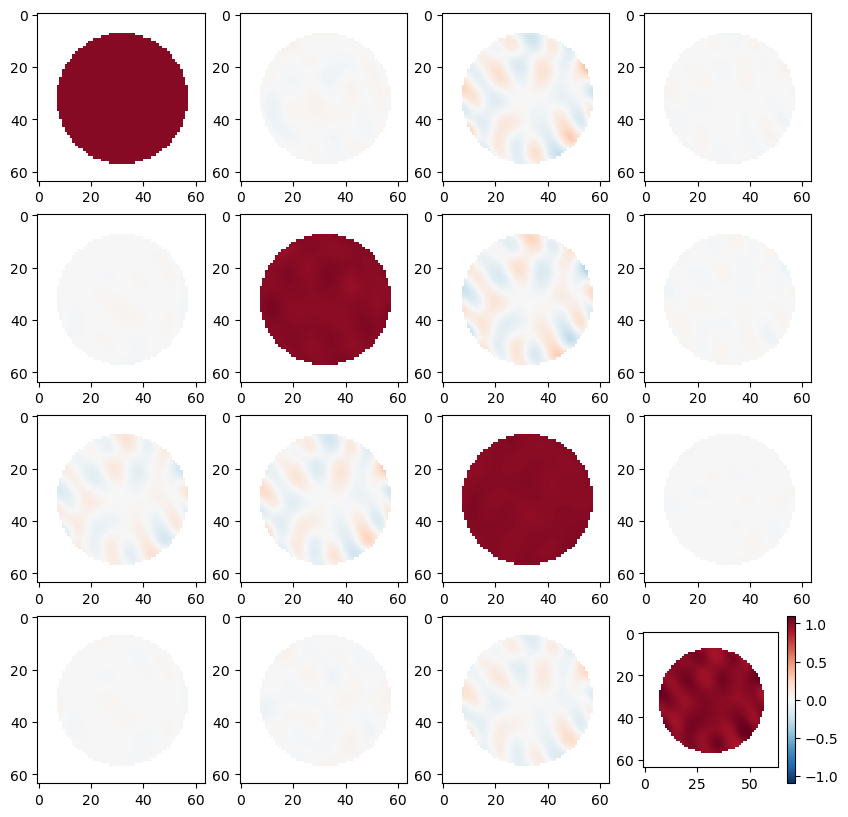

In [18]:
from katsu.mueller import decompose_retarder, retardance_from_mueller
lyot_stop = circle(0.8, r)
plt.style.use("default")
plot_square(M_meas / M_meas[..., 0, 0, None, None] / lyot_stop[...,None,None], vmin=-1.1, vmax=1.1)

In [19]:
from katsu.mueller import retardance_from_mueller
ret = retardance_from_mueller(M_meas / M_meas[..., 0, 0, None, None] * lyot_stop[..., None, None])

/Users/kaladin/katsu/katsu/mueller.py:828: RuntimeWarning: invalid value encountered in arccos
  retardance = np.arccos(tracem - 1)


/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/3067273719.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(np.degrees(ret) / lyot_stop * lyot_stop, cmap="RdBu_r")
/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_41128/3067273719.py:13: RuntimeWarning: invalid value encountered in multiply
  plt.imshow(np.degrees(ret) / lyot_stop * lyot_stop, cmap="RdBu_r")


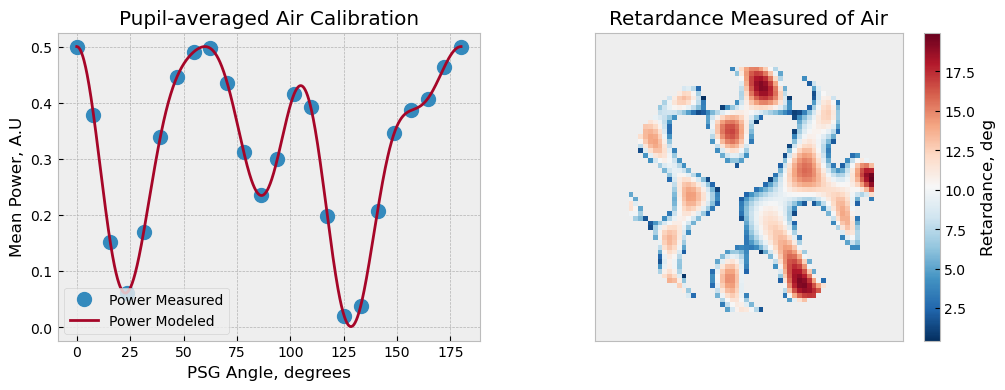

In [20]:
plt.figure(figsize=[12,4])
plt.style.use("bmh")
plt.subplot(121)
plt.plot(psg_angles, mean_power, marker="o", linestyle="None", markersize=10, label="Power Measured")
plt.plot(psg_angles_highsample, power_modeled, linestyle="solid", label="Power Modeled")
plt.ylabel("Mean Power, A.U")
plt.xlabel("PSG Angle, degrees")
plt.title("Pupil-averaged Air Calibration")
plt.legend()

plt.subplot(122)
plt.title("Retardance Measured of Air")
plt.imshow(np.degrees(ret) / lyot_stop * lyot_stop, cmap="RdBu_r")
plt.colorbar(label="Retardance, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

# Perform the Spatial Calibration

In [21]:
# Init retardance, PSG
coeffs_spatial_ret_psg = np.zeros(len(basis))
coeffs_spatial_ret_psg[0] = np.pi / 2

# Init angle, PSG
coeffs_spatial_ang_psg = (np.zeros(len(basis)))

# Init retardance, PSA
coeffs_spatial_ret_psa = np.zeros(len(basis))
coeffs_spatial_ret_psa[0] = np.pi / 2

# Init angle, PSA
coeffs_spatial_ang_psa = np.zeros(len(basis))

x0 = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])

In [22]:
set_backend_to_jax()

In [23]:
power_experiment_masked = np.copy(power_experiment)
power_experiment_masked = power_experiment_masked.at[np.isnan(power_experiment)].set(1e-10)

In [24]:
# need to define a new loss function
from jax import value_and_grad
def loss_jax(x):
    diff = forward_simulate(x) - power_experiment_masked
    diffsq = diff**2
    return np.sum(diffsq[A==1])

loss_fg = value_and_grad(loss_jax)

In [25]:
MAX_ITERS = 100

with tqdm(total=MAX_ITERS) as pbar:
    results_jax = minimize(loss_fg, x0=x0, callback=callback, method="L-BFGS-B", jac=True,
                       options={"maxiter": MAX_ITERS, "disp":False})

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


In [26]:
print("Finite Differences Squared Error = ", results.fun)
print("Autodiff Squared Error = ", results_jax.fun)

Finite Differences Squared Error =  3.3036987211053016e-09
Autodiff Squared Error =  1.446048320873195e-06


So as we knew, this method lets us fit to the universe. While we aren't doing it here, one can imagine a variant of this technique where power measurements are taken after rotating the PSG and PSA in sequence. In other words, one would include a frame after rotating the PSG, and then another frame after rotating the PSA. 

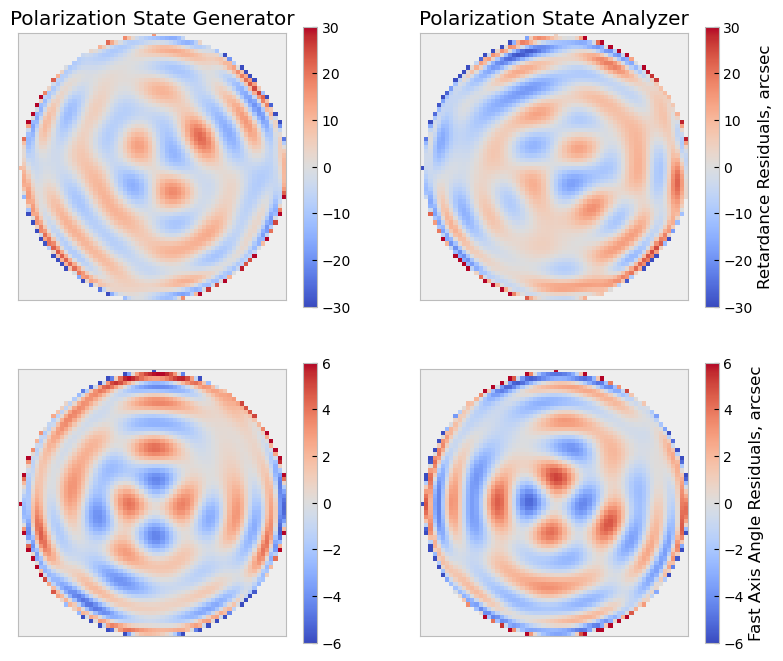

In [27]:
# Did we actually re-create the retardance / fast axis?
vlim_ret = 30
vlim_ang = 6
cmap = "coolwarm"
scale = 3600

# extract the coefficients
modeled_coeffs_spatial_ret_psg = results_jax.x[2 : 2 + 1*len(basis)]
modeled_coeffs_spatial_ang_psg = results_jax.x[2 + 1*len(basis):(2 + 2*len(basis))]
modeled_coeffs_spatial_ret_psa = results_jax.x[2 + 2*len(basis):(2 + 3*len(basis))]
modeled_coeffs_spatial_ang_psa = results_jax.x[2 + 3*len(basis):(2 + 4*len(basis))]


retardance_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psg)
retardance_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psa)
angle_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psg)
angle_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psa)

plt.figure(figsize=[9.5,8])
plt.subplot(221)
plt.title("Polarization State Generator")
plt.imshow(np.degrees(retardance_psg_modeled - retardance_psg) * scale / A, cmap=cmap, vmin=-vlim_ret, vmax=vlim_ret)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow(np.degrees(retardance_psa_modeled - retardance_psa) * scale / A, cmap=cmap, vmin=-vlim_ret, vmax=vlim_ret)
plt.colorbar(label="Retardance Residuals, arcsec")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg_modeled - angle_psg) * scale / A, cmap=cmap, vmin=-vlim_ang, vmax=vlim_ang)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(224)
plt.imshow(np.degrees(angle_psa_modeled - angle_psa) * scale / A, cmap=cmap, vmin=-vlim_ang, vmax=vlim_ang)
plt.colorbar(label="Fast Axis Angle Residuals, arcsec")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

Try out doing the polarimetric data reduction - remember to set it up with rotated bases!

In [33]:
psg_pol = linear_polarizer(results_jax.x[0], shape=[NPIX, NPIX, NMEAS])
psa_pol = linear_polarizer(results_jax.x[1], shape=[NPIX, NPIX, NMEAS])

psg_retardances, psa_retardances = [], []
psg_fast_axes, psa_fast_axes = [], []

for rot_psg in np.radians(psg_angles):

    rot_psa = rot_psg * 2.5

    # Get the rotated spatial basis
    basis_psg = np.asarray(construct_zern_basis(r, t + rot_psg))
    basis_psa = np.asarray(construct_zern_basis(r, t + rot_psa))

    # compute retardances
    psg_retardance = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ret_psg)
    psa_retardance = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ret_psa)

    # compute fast axes
    psg_fast_axis = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ang_psg)
    psa_fast_axis = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ang_psa)

    # store arrays in list
    psg_retardances.append(psg_retardance)
    psa_retardances.append(psa_retardance)
    psg_fast_axes.append(psg_fast_axis)
    psa_fast_axes.append(psa_fast_axis)

psg_retardances = np.asarray(psg_retardances)
psa_retardances = np.asarray(psa_retardances)
psg_fast_axes = np.asarray(psg_fast_axes)
psa_fast_axes = np.asarray(psa_fast_axes)

psg_retardances = np.moveaxis(psg_retardances, 0, -1)
psa_retardances = np.moveaxis(psa_retardances, 0, -1)
psg_fast_axes = np.moveaxis(psg_fast_axes, 0, -1)
psa_fast_axes = np.moveaxis(psa_fast_axes, 0, -1)

psg_fast_axes = np.radians(psg_angles)[None, None]
psa_fast_axes = np.radians(psg_angles * 2.5)[None, None]

# retardance_psg_modeled_broad = np.broadcast_to(retardance_psg_modeled, [NMEAS,NPIX, NPIX])
# retardance_psa_modeled_broad = np.broadcast_to(retardance_psa_modeled, [NMEAS, NPIX, NPIX])
# retardance_psg_modeled_broad = np.moveaxis(retardance_psg_modeled_broad, 0, -1)
# retardance_psa_modeled_broad = np.moveaxis(retardance_psa_modeled_broad, 0, -1)

psg_wvp = linear_retarder(psg_fast_axes, psg_retardances, shape=[NPIX, NPIX, NMEAS])
psa_wvp = linear_retarder(psa_fast_axes, psa_retardances, shape=[NPIX, NPIX, NMEAS])

PSG = (psg_wvp @ psg_pol)
PSA = (psa_pol @ psa_wvp)
Winv = drrp_data_reduction_matrix(PSG, PSA, invert=True)

M_meas = Winv @ (N_PHOTONS * power_experiment)[..., None]
M_meas = np.reshape(M_meas[..., 0], [NPIX, NPIX, 4, 4])

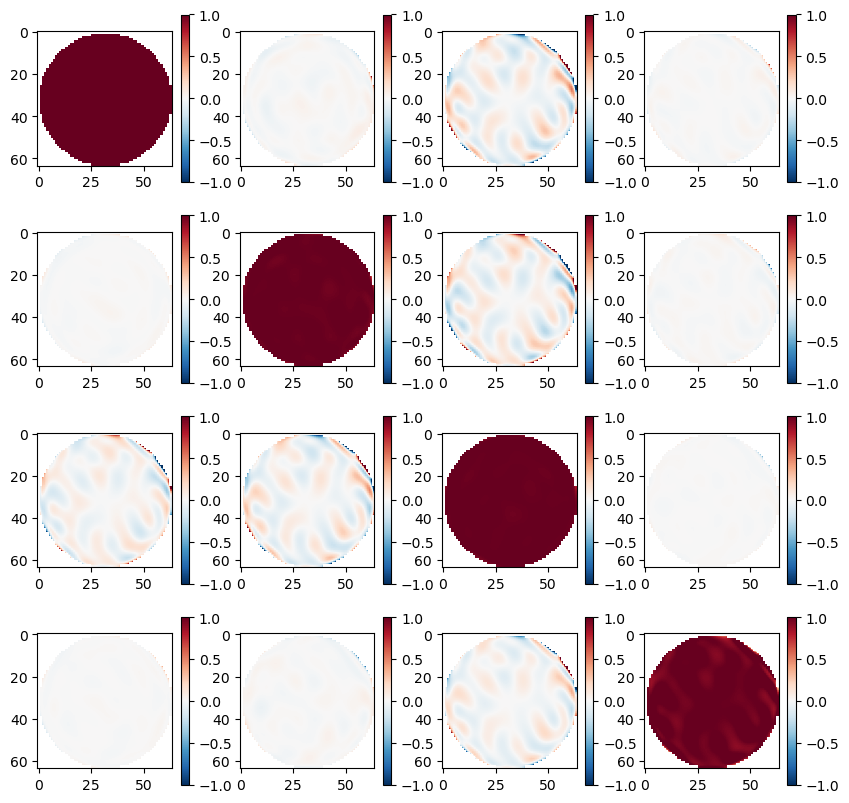

In [34]:
plt.style.use("default")
plot_square(M_meas / M_meas[...,0,0, None, None] / A[..., None, None], vmin=-1, vmax=1, common_cbar=False)

([], [])

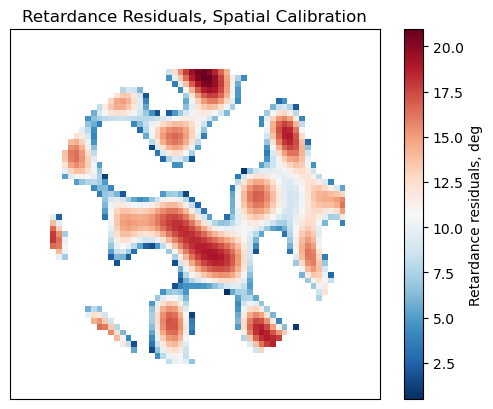

In [35]:
ret = retardance_from_mueller(M_meas)
# ret -= np.mean(ret[lyot_stop==1])
plt.figure()
plt.title("Retardance Residuals, Spatial Calibration")
plt.imshow(np.degrees(ret / lyot_stop), cmap="RdBu_r")
plt.colorbar(label="Retardance residuals, deg")
plt.xticks([],[])
plt.yticks([],[])

The constant angular offset has to do with air measurements being invariant under rotation, so the fact that the PSG and PSA are off by the same constant means that we optimized them to 1/100th of a degree. Not too shabby. Next up is to try this again (just using the AD'd calibration routine) subject to noisy frames

In [30]:
# how do we add photon noise to a frame? Gotta discretise I guess
test_frame = power_experiment[..., 5]

test_frame_nphotons = (100 * test_frame)
test_frame_noisy = poisson.logpmf(k=tnp.random.poisson(test_frame_nphotons), mu=test_frame_nphotons)
plt.imshow(test_frame_noisy / A, cmap="plasma")
plt.colorbar()

NameError: name 'poisson' is not defined

/var/folders/hc/vdwypdzx4rq1mm1_k3jv78_80000gn/T/ipykernel_24989/2242075565.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(test_frame_nphotons / A, cmap="gray", vmax=43, vmin=40)


([], [])

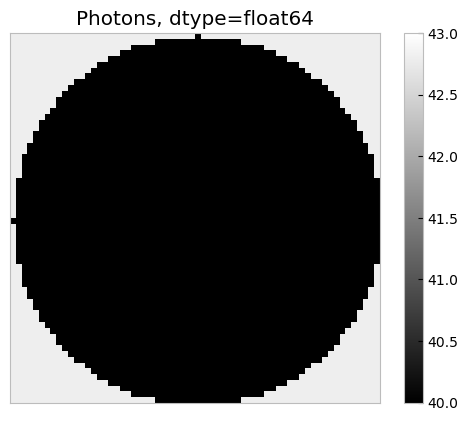

In [31]:
plt.title(f"Photons, dtype={test_frame_nphotons.dtype}")
plt.imshow(test_frame_nphotons / A, cmap="gray", vmax=43, vmin=40)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])

Encountering an issue with jax's poisson.logpmf. Looks like you need integer values to go into the logpmf, but can't propagate a gradient through it. Alas

In [32]:
N_PHOTONS = 1000

# define the maximum likelihood estimator
from scipy.stats import poisson as poisson_sp
from jax.scipy.stats import poisson, norm
from jax import jacrev
from jax import random

key = random.key(43)

# Make the photon noisy images
noisy_power_experiment = []
for i in range(NMEAS):
    binned_img = random.poisson(key, lam=N_PHOTONS * power_experiment[..., i])
    binned_int = binned_img
    noisy_power_experiment.append(binned_int)


# recall which value goes where, I think it's the following?
# poisson.logpmf(k=value_measured, mu=value_modeled)
# this returns infinite values so I suspect not, let's flip it lol

def log_likelihood(x):

    # simulate the power
    power_simulate = (forward_simulate(x) * N_PHOTONS)
    loglike = poisson.logpmf(k=noisy_power_experiment[0],
                                        mu=power_simulate[..., 0])

    for i in range(1, NMEAS):

        loglike = loglike + poisson.logpmf(k=noisy_power_experiment[i],
                                            mu=power_simulate[..., i])
            
        return -np.sum(np.asarray(loglike)[A==1])

loglike_fg = value_and_grad(log_likelihood)
loglike_fg(x0)

(Array(1140443.32006572, dtype=float64),
 Array([-1.33819109e+06, -1.45617992e+06, -2.12119605e+05, -1.81837426e+01,
         5.75981213e+01,  6.18021980e+02, -4.96596390e+01, -8.55608899e+01,
         7.35013473e+00,  5.47406099e+01, -7.55715256e+01,  6.24352322e+01,
         5.47870072e+02, -7.97180887e+00, -2.71797208e+01,  7.29885544e+02,
         4.76986961e+02,  8.36503096e+01,  8.31081860e+01,  1.03308139e+02,
        -6.22346696e+01, -2.74767126e+01,  8.44561706e+01,  5.45619679e+02,
        -2.90252704e+01, -7.28264042e-02,  4.42564290e+02,  7.27402304e+02,
         3.30141531e+01, -2.55617798e+01,  6.93252538e+01,  4.79657418e+01,
        -5.39252828e+01,  5.46078656e+01,  9.49127138e+01, -1.62948243e+01,
         5.58988879e+01,  7.78332589e+01,  5.23015569e+02, -1.05319992e+00,
        -2.65019574e+01,  7.07889958e+02,  4.35572075e+02, -1.04432771e+01,
         5.00703097e+01,  3.00602763e+02,  5.88349445e+02,  3.84376829e+01,
         3.74665877e+01,  9.09267387e+01, -2.23

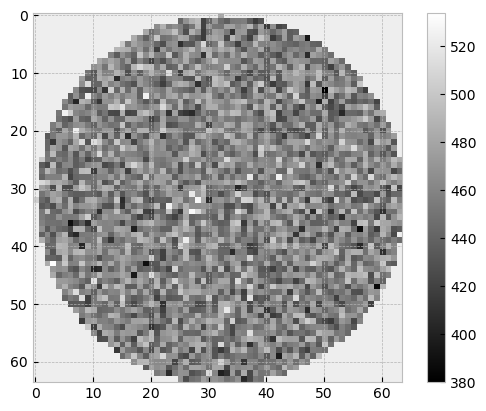

In [33]:
plt.imshow(noisy_power_experiment[10] / A,cmap="gray")
plt.colorbar()

In [34]:
MAX_ITERS = 100

with tqdm(total=MAX_ITERS) as pbar:
    results_jax = minimize(loglike_fg, x0=x0, callback=callback, method="L-BFGS-B", jac=True,
                       options={"maxiter": MAX_ITERS})

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [35]:
print(results_jax)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 23134.49922187128
        x: [ 9.514e-01  4.898e-01 ...  1.060e-03 -3.558e-03]
      nit: 100
      jac: [-2.638e+02 -1.134e+02 ...  2.263e+00 -1.072e+01]
     nfev: 112
     njev: 112
 hess_inv: <510x510 LbfgsInvHessProduct with dtype=float64>


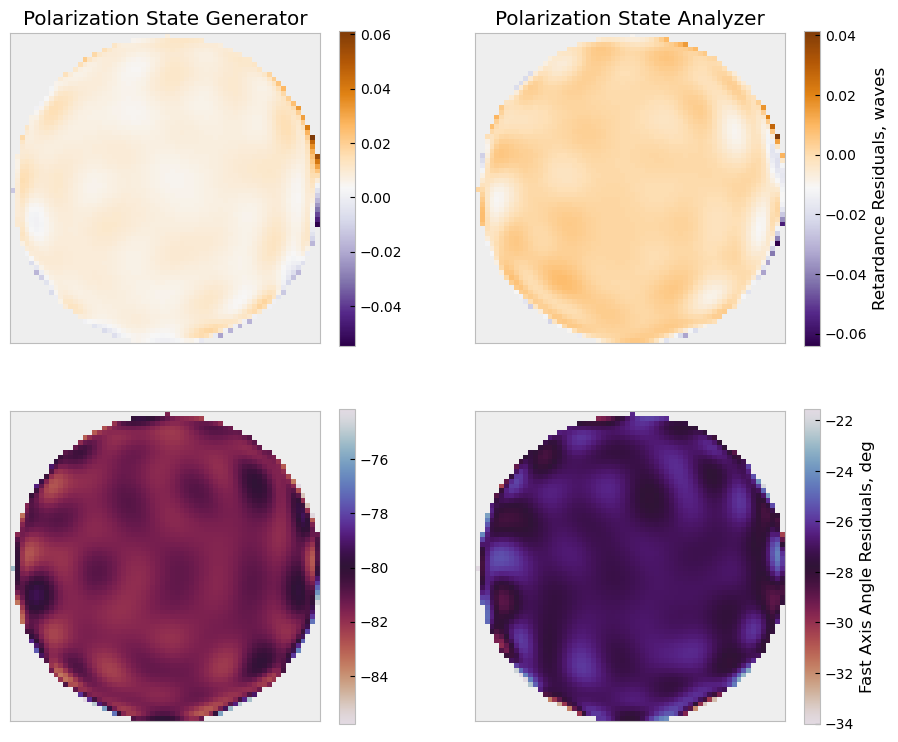

In [36]:
# Did we actually re-create the retardance / fast axis?

# extract the coefficients
modeled_coeffs_spatial_ret_psg = results_jax.x[2 : 2 + 1*len(basis)]
modeled_coeffs_spatial_ang_psg = results_jax.x[2 + 1*len(basis):(2 + 2*len(basis))]
modeled_coeffs_spatial_ret_psa = results_jax.x[2 + 2*len(basis):(2 + 3*len(basis))]
modeled_coeffs_spatial_ang_psa = results_jax.x[2 + 3*len(basis):(2 + 4*len(basis))]


retardance_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psg)
retardance_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psa)
angle_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psg)
angle_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psa)

plt.figure(figsize=[11,9])
plt.subplot(221)
plt.title("Polarization State Generator")
plt.imshow((retardance_psg_modeled - retardance_psg) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow((retardance_psa_modeled - retardance_psa) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar(label="Retardance Residuals, waves")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg_modeled - angle_psg) / A, cmap="twilight_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(224)
plt.imshow(np.degrees(angle_psa_modeled - angle_psa) / A, cmap="twilight_r")
plt.colorbar(label="Fast Axis Angle Residuals, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()